#  Interactions at baits

In this Jupyter notebook, the classes ``BaitedDigest`` and ``BaitedDigestSet`` are demonstrated.

The class ``BaitedDigest`` can be used to group interactions according to the baits in which they end. Within this class, interactions are further differntiated according to interaction category (``DI``, ``UIR``, ``UI`` and ``ALL``) and the enrichment status of the two digests (``NE`` and ``EN``). Interactions with the enrichment state `NN` or ``EE`` cannot be assigned unabgiuously to a baited digests and, therefore, are not taken into account. However, for capture Hi-C data, such interactions make up only a small percentage (around 10% on average).

The class ``BaitedDigestSet`` can be used to manage a number of ``BaitedDigest`` objects. At its core, it is a dictionary in which ``BaitedDigest`` objects are stored, with the coordinates of the digests serving as keys.

This structuring of the data enables properties of interactions that end in the same baited digest to be investigated and compared for the different interaction categories and enrichment states.

## Setting up the notebook

In [1]:
import sys
import os
import pandas
import copy
sys.path.append("..")
from diachr import DiachromaticInteractionSet
from diachr import BaitedDigest
from diachr import BaitedDigestSet

## Input file

We have prepared a small test file in ``Diachromatic11`` format (already contains the  interaction categories ``DI``, ``UIR`` and ``UI``) that only contains interactions on chromosome ``chr21`` and ``chr22``.

In [142]:
# Interactions on 'chr21' and 'chr22' only
INTERACTION_FILE = "../tests/data/baited_digests_d11_interaction_test_file.tsv.gz"
OUT_PREFIX = "TEST_FILE_1"

# 100,000 randomly selected interactions
#INTERACTION_FILE = "../tests/data/baited_digests_d11_interaction_test_file_2.tsv.gz"
#OUT_PREFIX = "TEST_FILE_2"


INTERACTION_FILE = "../DICer_interactions/HT/FDR005/CHC/JAV_MK_RALT_20000_ht_fdr0.05_evaluated_and_categorized_interactions_chr10.tsv.gz"
OUT_PREFIX = "TEST_FILE_3"

In [38]:
CELL_TYPE_SHORT = 'HC_POOLED'
PROTOCOL = 'HC'
MIN_I_DIST = '20000'
if PROTOCOL == 'CHC':
    MIN_I_DIST = '20000'
RPC_RULE = 'ht'
FDR = '05'
if PROTOCOL == 'CHC':
    INTERACTION_FILE = '../DICer_interactions/' + RPC_RULE.upper() + '/FDR0' + FDR + '/CHC/JAV_' + CELL_TYPE_SHORT + '_RALT_20000_' + RPC_RULE + '_fdr0.' + FDR + '_evaluated_and_categorized_interactions.tsv.gz'
    OUT_PREFIX = 'JAV_' + CELL_TYPE_SHORT + '_CHC_RALT_' + MIN_I_DIST + '_' + RPC_RULE.lower()
if PROTOCOL == 'HC_POOLED':
    INTERACTION_FILE = '../DICer_interactions/HT/FDR005/HC/20000/JAV_ALL_HC_RALL_ALT_20000_ht_fdr0.05_evaluated_and_categorized_interactions.tsv.gz'
    OUT_PREFIX = 'JAV_' + 'POOLED_HC_FDR005' + '_HC_RALT_20000_' + RPC_RULE.lower()
if PROTOCOL == 'HC':
    INTERACTION_FILE = '../DICer_interactions/' + RPC_RULE.upper() + '/FDR0' + FDR + '/HC/' + MIN_I_DIST + '/JAV_' + CELL_TYPE_SHORT + '_HC_RALT_' + MIN_I_DIST + '_' + RPC_RULE + '_fdr0.' + FDR + '_evaluated_and_categorized_interactions.tsv.gz'
    OUT_PREFIX = 'JAV_' + CELL_TYPE_SHORT + '_HC_RALT_'  + MIN_I_DIST + '_' + RPC_RULE.lower()

## Creation of a ``BaitedDigestSet``

First, we create a ``DiachromaticInteractionSet`` from the test file.

In [3]:
# Create DiachromaticInteractionSet
d11_interaction_set = DiachromaticInteractionSet(rpc_rule = 'ht')
d11_interaction_set.parse_file(
    i_file = INTERACTION_FILE,
    verbose = True)

[INFO] Parsing Diachromatic interaction file ...
	[INFO] ../DICer_interactions/ST/FDR005/HC/20000/JAV_MAC_M0_HC_RALT_20000_st_fdr0.05_evaluated_and_categorized_interactions.tsv.gz
	[INFO] Set size: 4,170
[INFO] ... done.


Next, we create a ``BaitedDigestSet`` and pass the ``DiachromaticInteractionSet``.

In [4]:
baited_digest_set = BaitedDigestSet()
read_interactions_info_dict = baited_digest_set.ingest_interaction_set(d11_interaction_set, verbose=True)

[INFO] Reading interactions and group them according to chromosomes and baited digests ...
	[INFO] Total number of interactions read: 4,170
	[INFO] Total number of baited digests: 439
[INFO] ... done.


The function ``get_ingest_interaction_set_info_report()`` returns a string with more detailed information on the ingestion.

In [5]:
print(baited_digest_set.get_ingest_interaction_set_info_report())

[INFO] Report on ingestion of interactions:
	[INFO] Total number of interactions read: 4,170
	[INFO] Discarded NN and EE interactions: 3,566
	[INFO] Total number of ingested NE and EN interactions: 604
	[INFO] Broken down by interaction category and enrichment status: 
		[INFO] DIX: 
			[INFO] NE: 0
			[INFO] EN: 0
		[INFO] DI: 
			[INFO] NE: 0
			[INFO] EN: 0
		[INFO] UIR: 
			[INFO] NE: 0
			[INFO] EN: 0
		[INFO] UI: 
			[INFO] NE: 310
			[INFO] EN: 294
		[INFO] ALL: 
			[INFO] NE: 310
			[INFO] EN: 294
	[INFO] Total number of baited digests: 439
[INFO] End of report.



And the function ``get_ingest_interaction_set_table_row()`` returns the same information in table format.

In [6]:
print(baited_digest_set.get_ingest_interaction_set_table_row())

:TR_INGESTION:	TOTAL_INTERACTIONS_READ	DISCARDED	INGESTED	DIX_NE	DIX_EN	DI_NE	DI_EN	UIR_NE	UIR_EN	UI_NE	UI_EN	ALL_NE	ALL_EN	BAITED_DIGESTS
:TR_INGESTION:	5232757	350558	4882199	21	30	90543	93420	91530	92433	2255402	2258820	2437496	2444703	21652



### Explanation of the data structure

In the object ``baited_digest_set``, the chromosomes are first grouped according to chromosomes. For example, ``baited_digest_set._baited_digest_dict['chr21']`` all ``BaitedDigest`` object that were created for ``chr21``.

In [7]:
dict_all_baited_digest_objects_on_chr21 = baited_digest_set._baited_digest_dict['chr21']

A individual ``BaitedDigest`` object can be accessed via its digest coordinates.

In [8]:
individual_baited_digest_object_on_chr21 = baited_digest_set._baited_digest_dict['chr21']['chr21\t33167499\t33175012']

An ``BaitedDigest``, contains all interactions that end in this digest, spearted by interaction category and enrichment status. Here, as an example, an interaction of category ``DI`` with enricchment state ``NE``.

In [9]:
baited_digest_set._baited_digest_dict['chr21']['chr21\t33167499\t33175012'].interactions['DI']['NE'][0].get_category()

'DI'

In [10]:
baited_digest_set._baited_digest_dict['chr21']['chr21\t33167499\t33175012'].interactions['DI']['NE'][0].enrichment_status_tag_pair

'NE'

## Write interactions at baited digests to BED file

In [23]:
baited_digest_set.write_bed_files_with_baited_interactions(
    out_prefix = 'bed_files/MK_RALT_HTR_CHR1_HC',
    chromosomes=['chr1'])

## Iterate baited digests

In [55]:
di_baited_digests = 0
di_num_total = 0
for chrom in baited_digest_set._baited_digest_dict.keys():
    for baited_digest_key, baited_digest in baited_digest_set._baited_digest_dict[chrom].items():
        di_num = len(baited_digest.interactions['DI']['NE'] + baited_digest.interactions['DI']['EN'])
        uir_num = len(baited_digest.interactions['UIR']['NE'] + baited_digest.interactions['UIR']['EN'])
        ui_num = len(baited_digest.interactions['UI']['NE'] + baited_digest.interactions['UI']['EN'])
        all_num = len(baited_digest.interactions['ALL']['NE'] + baited_digest.interactions['ALL']['EN'])
        di_frac = (di_num + 1)/(di_num + uir_num + 1)
        
        di_num_total += di_num
        
        if 1 < di_num and 0.5 > di_frac:
            di_baited_digests += 1
            print('-----------')
            print(baited_digest_key)
            print(di_num)
            print(uir_num)
            print(ui_num)
            print(all_num)
            print(di_frac)
            
print('==============')            
print(di_baited_digests)
print(di_num_total)

-----------
chr1	210372572	210374432
3
7
284
294
0.36363636363636365
-----------
chr1	185315549	185326724
9
20
394
423
0.3333333333333333
-----------
chr1	93878715	93884024
4
21
369
394
0.19230769230769232
-----------
chr1	204148773	204157398
3
13
269
285
0.23529411764705882
-----------
chr1	46170733	46175558
2
24
290
317
0.1111111111111111
-----------
chr1	234270867	234272645
2
27
509
538
0.1
-----------
chr1	99847606	99852245
2
22
379
403
0.12
-----------
chr1	152768962	152778325
7
14
234
255
0.36363636363636365
-----------
chr1	219387996	219402096
5
19
438
462
0.24
-----------
chr1	24107977	24117449
4
8
117
129
0.38461538461538464
-----------
chr1	193056766	193062263
14
19
364
397
0.4411764705882353
-----------
chr1	183469292	183478197
16
23
428
467
0.425
-----------
chr1	165827330	165829347
2
6
84
92
0.3333333333333333
-----------
chr1	236298062	236305144
2
20
343
365
0.13043478260869565
-----------
chr1	154990292	154994173
4
7
93
104
0.4166666666666667
-----------
chr1	164637876	1

302
0.27586206896551724
-----------
chr1	52031897	52034512
7
19
374
400
0.2962962962962963
-----------
chr1	43419314	43421429
8
18
325
351
0.3333333333333333
-----------
chr1	7768502	7773212
3
10
390
403
0.2857142857142857
-----------
chr1	155343619	155347627
3
18
219
240
0.18181818181818182
-----------
chr1	170084236	170096839
10
16
360
386
0.4074074074074074
-----------
chr1	20659953	20667166
2
15
329
346
0.16666666666666666
-----------
chr1	27834079	27836073
4
21
278
303
0.19230769230769232
-----------
chr1	40256116	40271963
4
23
257
284
0.17857142857142858
-----------
chr1	193123981	193137593
2
22
471
495
0.12
-----------
chr1	91386395	91395052
8
12
431
451
0.42857142857142855
-----------
chr1	237039183	237043968
2
12
336
350
0.2
-----------
chr1	233293807	233298072
5
30
638
673
0.16666666666666666
-----------
chr1	240653246	240657862
4
8
288
300
0.38461538461538464
-----------
chr1	172530041	172534263
4
20
495
519
0.2
-----------
chr1	184973078	184981497
6
29
503
538
0.19444444444

0.25
-----------
chr1	116903918	116907451
6
15
343
364
0.3181818181818182
-----------
chr1	51516587	51524976
5
20
298
323
0.23076923076923078
-----------
chr1	34666327	34673065
5
14
345
364
0.3
-----------
chr1	231611860	231616765
4
18
381
403
0.21739130434782608
-----------
chr1	215566328	215573070
3
13
284
300
0.23529411764705882
-----------
chr1	152620266	152627181
8
13
248
269
0.4090909090909091
-----------
chr1	56964462	56968721
3
20
457
480
0.16666666666666666
-----------
chr1	42160923	42168703
2
5
83
90
0.375
-----------
chr1	180610648	180639986
6
15
242
263
0.3181818181818182
-----------
chr1	209428772	209435633
2
7
400
409
0.3
-----------
chr1	40282188	40282495
5
20
268
293
0.23076923076923078
-----------
chr1	231038637	231041859
2
26
356
384
0.10344827586206896
-----------
chr1	83997921	84000961
13
19
387
419
0.42424242424242425
-----------
chr1	107136718	107142739
2
11
418
431
0.21428571428571427
-----------
chr1	28548856	28553470
3
7
206
216
0.36363636363636365
-----------


chr17	35093124	35096452
6
18
363
387
0.28
-----------
chr17	58628908	58632535
7
17
241
265
0.32
-----------
chr17	48604342	48605456
10
15
215
240
0.4230769230769231
-----------
chr17	14068089	14070939
13
24
455
492
0.3684210526315789
-----------
chr17	62802909	62810773
4
7
86
97
0.4166666666666667
-----------
chr17	47645193	47651633
9
14
213
236
0.4166666666666667
-----------
chr17	81635796	81667893
3
7
116
126
0.36363636363636365
-----------
chr17	41417805	41429038
2
17
229
248
0.15
-----------
chr17	80544525	80547274
2
12
234
248
0.2
-----------
chr17	50147899	50152663
3
8
213
224
0.3333333333333333
-----------
chr17	12665383	12672456
8
12
336
356
0.42857142857142855
-----------
chr17	56590521	56603779
7
9
233
249
0.47058823529411764
-----------
chr17	10880291	10888568
5
26
520
551
0.1875
-----------
chr17	40771948	40774337
4
15
252
271
0.25
-----------
chr17	77279295	77286063
4
11
280
295
0.3125
-----------
chr17	7075669	7082088
2
13
134
149
0.1875
-----------
chr17	48428616	4843804

2
22
472
496
0.12
-----------
chr6	5995347	6011725
2
17
531
550
0.15
-----------
chr6	127454051	127466516
3
20
432
455
0.16666666666666666
-----------
chr6	96919154	96926808
6
11
303
320
0.3888888888888889
-----------
chr6	36592654	36594815
2
16
251
269
0.15789473684210525
-----------
chr6	99424748	99445855
3
5
141
149
0.4444444444444444
-----------
chr6	154876819	154885747
4
23
340
367
0.17857142857142858
-----------
chr6	93410833	93421299
3
17
505
525
0.19047619047619047
-----------
chr6	41026919	41044401
2
17
335
354
0.15
-----------
chr6	32762563	32765158
3
5
83
91
0.4444444444444444
-----------
chr6	39318549	39328179
3
19
377
399
0.17391304347826086
-----------
chr6	39299372	39315490
4
12
255
271
0.29411764705882354
-----------
chr6	79631028	79633912
7
24
412
443
0.25
-----------
chr6	156378135	156380691
6
34
609
649
0.17073170731707318
-----------
chr6	132552286	132559395
11
20
402
433
0.375
-----------
chr6	77460849	77463875
2
15
483
500
0.16666666666666666
-----------
chr6	3377

321
334
0.2857142857142857
-----------
chr6	114863037	114867862
2
13
467
482
0.1875
-----------
chr6	125745590	125751098
3
29
459
491
0.12121212121212122
-----------
chr6	33078474	33085656
2
14
281
297
0.17647058823529413
-----------
chr6	30095853	30115777
5
7
149
161
0.46153846153846156
-----------
chr6	83427435	83432428
2
8
230
240
0.2727272727272727
-----------
chr6	43763848	43775520
3
12
116
131
0.25
-----------
chr6	26497609	26502906
3
8
137
148
0.3333333333333333
-----------
chr6	36585147	36590717
3
21
322
346
0.16
-----------
chr6	132742594	132753029
2
7
223
232
0.3
-----------
chr6	49740432	49745691
3
12
129
144
0.25
-----------
chr6	33450321	33455881
2
8
186
196
0.2727272727272727
-----------
chr6	32129502	32177057
5
8
180
193
0.42857142857142855
-----------
chr6	37030349	37051038
5
11
148
164
0.35294117647058826
-----------
chr6	50045354	50049989
2
11
388
401
0.21428571428571427
-----------
chr6	52356725	52365348
5
7
166
178
0.46153846153846156
-----------
chr6	53662306	53665

116
0.4
-----------
chr15	67062018	67069577
3
22
500
525
0.15384615384615385
-----------
chr15	77069973	77082389
3
15
266
284
0.21052631578947367
-----------
chr15	45446127	45450209
2
10
123
135
0.23076923076923078
-----------
chr15	48182714	48192613
6
10
371
387
0.4117647058823529
-----------
chr15	98025694	98028754
2
10
210
222
0.23076923076923078
-----------
chr15	71473738	71486687
2
9
221
232
0.25
-----------
chr15	60002298	60012325
4
12
230
246
0.29411764705882354
-----------
chr15	75448642	75456981
3
6
169
178
0.4
-----------
chr15	42546696	42550550
3
14
291
308
0.2222222222222222
-----------
chr15	64373141	64386400
2
7
109
118
0.3
-----------
chr15	33968125	33969093
7
32
449
488
0.2
-----------
chr15	90753519	90758768
5
9
191
205
0.4
-----------
chr15	80662851	80665757
4
6
165
175
0.45454545454545453
-----------
chr15	101641614	101650180
3
12
224
239
0.25
-----------
chr15	34334725	34339722
2
6
124
132
0.3333333333333333
-----------
chr15	56730641	56734320
3
10
278
291
0.2857142

-----------
chr19	51640215	51649009
9
11
163
183
0.47619047619047616
-----------
chr19	35527938	35530035
4
14
119
137
0.2631578947368421
-----------
chr19	56472236	56479719
7
16
312
335
0.3333333333333333
-----------
chr19	57470387	57477220
3
21
287
311
0.16
-----------
chr19	40209082	40218767
3
9
211
223
0.3076923076923077
-----------
chr19	49676937	49699626
5
7
109
121
0.46153846153846156
-----------
chr19	48964803	48966625
3
10
126
139
0.2857142857142857
-----------
chr19	57721265	57728367
10
15
219
244
0.4230769230769231
-----------
chr19	6492297	6499565
3
5
121
129
0.4444444444444444
-----------
chr19	33505389	33524324
2
6
116
124
0.3333333333333333
-----------
chr19	46947129	46955674
4
8
138
150
0.38461538461538464
-----------
chr19	41697928	41716163
2
9
163
174
0.25
-----------
chr19	35923391	35945183
3
7
100
110
0.36363636363636365
-----------
chr19	48347000	48363999
4
12
160
176
0.29411764705882354
-----------
chr19	45495172	45506243
2
4
32
38
0.42857142857142855
-----------
c

chr14	60639685	60640832
10
28
505
543
0.28205128205128205
-----------
chr14	100854130	100864254
2
17
295
314
0.15
-----------
chr14	78282877	78286510
3
13
252
268
0.23529411764705882
-----------
chr14	91059593	91061572
11
18
352
381
0.4
-----------
chr14	58769087	58777346
2
14
318
334
0.17647058823529413
-----------
chr14	57488276	57495510
3
6
318
327
0.4
-----------
chr14	24146291	24152278
3
9
112
124
0.3076923076923077
-----------
chr14	96796389	96799213
4
15
294
313
0.25
-----------
chr14	66503952	66508269
2
15
332
349
0.16666666666666666
-----------
chr14	23177985	23185098
7
11
265
283
0.42105263157894735
-----------
chr14	22835373	22849245
5
13
186
204
0.3157894736842105
-----------
chr14	80206276	80212788
2
11
537
550
0.21428571428571427
-----------
chr14	54857467	54866127
3
8
166
177
0.3333333333333333
-----------
chr14	77197115	77204855
5
8
273
286
0.42857142857142855
-----------
chr14	101038815	101049290
3
14
245
262
0.2222222222222222
-----------
chr14	93781391	93791531
2
16


24
477
509
0.2727272727272727
-----------
chr4	105549660	105552747
2
20
445
467
0.13043478260869565
-----------
chr4	75514163	75522202
3
15
285
303
0.21052631578947367
-----------
chr4	41256181	41258307
6
30
489
525
0.1891891891891892
-----------
chr4	145497455	145523327
3
15
289
307
0.21052631578947367
-----------
chr4	66275208	66283020
2
4
87
93
0.42857142857142855
-----------
chr4	164977325	164977885
8
13
379
400
0.4090909090909091
-----------
chr4	6269282	6272706
2
11
371
384
0.21428571428571427
-----------
chr4	38782363	38783022
4
20
554
578
0.2
-----------
chr4	110298234	110310438
4
8
187
199
0.38461538461538464
-----------
chr4	99155396	99163027
2
6
271
279
0.3333333333333333
-----------
chr4	6182620	6207392
2
10
413
425
0.23076923076923078
-----------
chr4	112805305	112821734
2
5
128
135
0.375
-----------
chr4	56814469	56824613
4
11
357
372
0.3125
-----------
chr4	108620106	108623847
4
9
393
406
0.35714285714285715
-----------
chr4	55123651	55135067
5
27
524
556
0.1818181818181

257
278
0.2727272727272727
-----------
chr12	80712681	80720659
3
17
408
428
0.19047619047619047
-----------
chr12	88580719	88581692
11
17
373
401
0.41379310344827586
-----------
chr12	62849113	62854414
2
21
292
315
0.125
-----------
chr12	68224226	68231509
6
25
408
439
0.21875
-----------
chr12	102190031	102205291
2
14
313
329
0.17647058823529413
-----------
chr12	124281453	124289241
2
15
248
265
0.16666666666666666
-----------
chr12	103718277	103728720
2
6
206
214
0.3333333333333333
-----------
chr12	57816917	57818856
3
8
223
234
0.3333333333333333
-----------
chr12	80405689	80406900
9
25
532
566
0.2857142857142857
-----------
chr12	10804576	10809199
11
14
321
346
0.46153846153846156
-----------
chr12	45552816	45560749
4
16
322
342
0.23809523809523808
-----------
chr12	102062091	102068173
2
6
169
177
0.3333333333333333
-----------
chr12	114681266	114685800
2
33
645
680
0.08333333333333333
-----------
chr12	116986777	116987978
2
20
386
408
0.13043478260869565
-----------
chr12	71664758

0.4642857142857143
-----------
chr12	49826945	49832978
2
4
268
274
0.42857142857142855
-----------
chr12	113601979	113603494
6
13
447
466
0.35
-----------
chr12	93674996	93683336
2
4
41
47
0.42857142857142855
-----------
chr12	27972653	27976629
8
23
443
474
0.28125
-----------
chr12	99636460	99648595
3
6
205
214
0.4
-----------
chr12	32106350	32117511
7
13
257
277
0.38095238095238093
-----------
chr12	108128967	108133794
4
7
224
235
0.4166666666666667
-----------
chr12	25648564	25648821
4
20
350
374
0.2
-----------
chr12	45213374	45220149
2
12
301
315
0.2
-----------
chr12	10208609	10223738
16
20
328
364
0.4594594594594595
-----------
chr12	64601415	64612958
4
10
141
155
0.3333333333333333
-----------
chr12	57779918	57786342
3
5
143
151
0.4444444444444444
-----------
chr12	48179600	48181386
2
12
258
272
0.2
-----------
chr12	103654568	103659532
3
7
281
291
0.36363636363636365
-----------
chr12	2810344	2823418
3
9
290
302
0.3076923076923077
-----------
chr12	128392909	128400099
3
5
454


-----------
chr10	19724083	19729122
2
19
496
517
0.13636363636363635
-----------
chr10	75374894	75391409
3
15
379
397
0.21052631578947367
-----------
chr10	98014095	98034670
3
17
392
412
0.19047619047619047
-----------
chr10	13344899	13360823
6
9
210
225
0.4375
-----------
chr10	114038784	114047692
6
13
318
337
0.35
-----------
chr10	78027228	78040235
3
10
330
343
0.2857142857142857
-----------
chr10	84317106	84329394
2
4
37
43
0.42857142857142855
-----------
chr10	76256440	76262698
6
18
437
461
0.28
-----------
chr10	101835443	101850894
2
8
158
168
0.2727272727272727
-----------
chr10	3762998	3770308
7
11
424
442
0.42105263157894735
-----------
chr10	104346942	104354284
11
15
249
275
0.4444444444444444
-----------
chr10	89203666	89207410
7
21
343
371
0.27586206896551724
-----------
chr10	100341251	100347724
3
6
103
112
0.4
-----------
chr10	27738554	27746877
2
13
263
278
0.1875
-----------
chr10	129952616	129964951
5
8
234
247
0.42857142857142855
-----------
chr10	114682375	114687651


2
9
221
232
0.25
-----------
chr8	81109687	81115002
3
17
401
421
0.19047619047619047
-----------
chr8	87972924	87975453
2
19
414
435
0.13636363636363635
-----------
chr8	38994025	38999491
9
11
188
208
0.47619047619047616
-----------
chr8	8889945	8894012
2
10
237
249
0.23076923076923078
-----------
chr8	127789486	127796032
5
28
592
625
0.17647058823529413
-----------
chr8	60691864	60692385
9
16
278
303
0.38461538461538464
-----------
chr8	134797277	134803832
6
13
382
401
0.35
-----------
chr8	109332807	109339796
10
30
427
467
0.2682926829268293
-----------
chr8	26034569	26046732
2
10
301
313
0.23076923076923078
-----------
chr8	139929319	139931563
7
31
322
360
0.20512820512820512
-----------
chr8	80400138	80412460
7
10
396
413
0.4444444444444444
-----------
chr8	135453776	135456992
2
11
369
382
0.21428571428571427
-----------
chr8	58814483	58817350
3
11
403
417
0.26666666666666666
-----------
chr8	124260240	124262081
12
21
304
337
0.38235294117647056
-----------
chr8	70666257	70674610
3

21
288
317
0.3
-----------
chr5	132055496	132069500
8
17
287
312
0.34615384615384615
-----------
chr5	96583480	96591344
2
12
279
293
0.2
-----------
chr5	154037090	154039967
2
15
395
412
0.16666666666666666
-----------
chr5	95698073	95701689
2
17
453
472
0.15
-----------
chr5	56858471	56869727
5
24
410
439
0.2
-----------
chr5	174047165	174057492
3
22
546
571
0.15384615384615385
-----------
chr5	1521511	1527112
3
8
136
147
0.3333333333333333
-----------
chr5	119609504	119613887
7
13
462
482
0.38095238095238093
-----------
chr5	58816009	58818486
4
27
617
648
0.15625
-----------
chr5	141186833	141192408
8
15
142
165
0.375
-----------
chr5	71718428	71720884
7
16
372
395
0.3333333333333333
-----------
chr5	52988323	52990934
6
17
425
448
0.2916666666666667
-----------
chr5	157136337	157145513
10
16
412
438
0.4074074074074074
-----------
chr5	35933566	35938991
4
18
443
465
0.21739130434782608
-----------
chr5	161846105	161847942
5
7
467
479
0.46153846153846156
-----------
chr5	151090027	1510

396
0.18181818181818182
-----------
chr5	83721488	83738935
2
12
458
472
0.2
-----------
chr5	13936767	13947197
5
11
408
424
0.35294117647058826
-----------
chr5	38416190	38430297
2
7
250
259
0.3
-----------
chr5	31637183	31643254
2
19
344
365
0.13636363636363635
-----------
chr5	90473246	90479094
3
10
354
367
0.2857142857142857
-----------
chr5	151347248	151348498
7
18
380
405
0.3076923076923077
-----------
chr5	138069367	138078200
6
22
240
268
0.2413793103448276
-----------
chr5	132467006	132476611
2
9
211
222
0.25
-----------
chr5	36154843	36159411
8
23
498
529
0.28125
-----------
chr5	135571425	135581485
4
8
284
296
0.38461538461538464
-----------
chr5	140173118	140180755
2
16
256
274
0.15789473684210525
-----------
chr5	159262913	159263986
16
25
635
676
0.40476190476190477
-----------
chr5	60428814	60434343
2
17
564
583
0.15
-----------
chr5	58489171	58496115
4
26
651
681
0.16129032258064516
-----------
chr5	41260172	41264233
3
20
444
467
0.16666666666666666
-----------
chr5	115621

0.19047619047619047
-----------
chr7	45564529	45580072
3
5
102
110
0.4444444444444444
-----------
chr7	53035220	53036957
3
5
246
254
0.4444444444444444
-----------
chr7	111090705	111094644
10
24
556
590
0.3142857142857143
-----------
chr7	104200594	104208529
3
22
541
566
0.15384615384615385
-----------
chr7	47948361	47954341
10
13
347
370
0.4583333333333333
-----------
chr7	158533754	158541727
2
17
341
360
0.15
-----------
chr7	95391872	95406001
2
11
301
314
0.21428571428571427
-----------
chr7	44328089	44335064
4
7
126
137
0.4166666666666667
-----------
chr7	139380622	139391001
2
11
291
304
0.21428571428571427
-----------
chr7	127649457	127658607
7
31
350
388
0.20512820512820512
-----------
chr7	82442388	82445841
3
21
445
469
0.16
-----------
chr7	113100478	113102207
3
13
349
365
0.23529411764705882
-----------
chr7	19114441	19120563
4
17
518
539
0.22727272727272727
-----------
chr7	107168532	107168994
3
16
311
330
0.2
-----------
chr7	27129810	27131404
2
13
388
403
0.1875
-----------

chr2	50958482	50962595
2
6
160
168
0.3333333333333333
-----------
chr2	4944382	4958907
5
9
264
278
0.4
-----------
chr2	159709699	159712791
9
18
270
297
0.35714285714285715
-----------
chr2	172457606	172471246
2
16
316
334
0.15789473684210525
-----------
chr2	149609225	149614284
9
13
379
401
0.43478260869565216
-----------
chr2	174330631	174343771
8
14
423
445
0.391304347826087
-----------
chr2	216369266	216372806
3
21
493
517
0.16
-----------
chr2	199324422	199332417
2
8
337
347
0.2727272727272727
-----------
chr2	114419798	114421040
8
14
368
390
0.391304347826087
-----------
chr2	239576411	239583913
3
22
296
321
0.15384615384615385
-----------
chr2	189658081	189664517
8
26
365
399
0.2571428571428571
-----------
chr2	69955506	69967776
2
11
215
228
0.21428571428571427
-----------
chr2	9504866	9509764
11
22
396
429
0.35294117647058826
-----------
chr2	68254527	68266712
3
10
191
204
0.2857142857142857
-----------
chr2	16659613	16666853
8
10
295
313
0.47368421052631576
-----------
chr2	24

26
542
573
0.1875
-----------
chr2	19899975	19903108
9
18
527
554
0.35714285714285715
-----------
chr2	144515256	144518553
5
28
645
678
0.17647058823529413
-----------
chr2	30186650	30200896
11
16
205
232
0.42857142857142855
-----------
chr2	197401393	197404095
5
25
565
595
0.1935483870967742
-----------
chr2	108217288	108219618
3
21
403
427
0.16
-----------
chr2	227160245	227168135
5
28
729
762
0.17647058823529413
-----------
chr2	170339738	170345593
3
15
408
426
0.21052631578947367
-----------
chr2	206083260	206087266
6
8
166
180
0.4666666666666667
-----------
chr2	85744284	85753246
5
25
243
273
0.1935483870967742
-----------
chr2	183077731	183079401
2
20
443
465
0.13043478260869565
-----------
chr2	72886978	72896766
9
25
504
538
0.2857142857142857
-----------
chr2	60065313	60071143
3
23
470
496
0.14814814814814814
-----------
chr2	186692060	186698285
2
9
185
196
0.25
-----------
chr2	173070126	173084479
3
9
306
318
0.3076923076923077
-----------
chr2	202266972	202277685
4
17
468
489

393
417
0.2
-----------
chr22	43232099	43236553
5
12
187
204
0.3333333333333333
-----------
chr22	25197422	25213017
4
15
300
319
0.25
-----------
chr22	23880850	23909048
3
5
189
197
0.4444444444444444
-----------
chr22	39562440	39571667
6
20
322
348
0.25925925925925924
-----------
chr22	30238668	30242960
6
10
201
217
0.4117647058823529
-----------
chr22	40861929	40862315
2
7
241
250
0.3
-----------
chr22	29314118	29330223
2
14
305
321
0.17647058823529413
-----------
chr22	36163149	36170042
12
18
277
307
0.41935483870967744
-----------
chr22	31749092	31754887
5
17
239
261
0.2608695652173913
-----------
chr22	32198677	32210406
2
8
131
141
0.2727272727272727
-----------
chr22	33724028	33726702
8
10
307
325
0.47368421052631576
-----------
chr22	19526639	19531205
2
11
167
180
0.21428571428571427
-----------
chr22	37050594	37053402
2
6
116
124
0.3333333333333333
-----------
chr22	36775350	36776391
5
23
317
345
0.20689655172413793
-----------
chr22	29571145	29589197
2
5
206
213
0.375
--------

466
0.13043478260869565
-----------
chr3	129591738	129610070
2
7
227
236
0.3
-----------
chr3	138944733	138949050
4
10
223
237
0.3333333333333333
-----------
chr3	155741419	155745893
7
19
633
659
0.2962962962962963
-----------
chr3	45000600	45014618
2
18
370
390
0.14285714285714285
-----------
chr3	110885406	110900355
2
4
78
84
0.42857142857142855
-----------
chr3	48439651	48445927
5
9
253
267
0.4
-----------
chr3	112560882	112562690
3
14
493
510
0.2222222222222222
-----------
chr3	196957779	196985702
7
9
244
260
0.47058823529411764
-----------
chr3	108090226	108098543
8
26
400
434
0.2571428571428571
-----------
chr3	193626850	193630240
3
21
406
430
0.16
-----------
chr3	175767048	175767696
4
24
654
682
0.1724137931034483
-----------
chr3	57688530	57706491
3
7
205
215
0.36363636363636365
-----------
chr3	111728535	111733271
5
27
434
466
0.18181818181818182
-----------
chr3	66495997	66502269
8
16
271
295
0.36
-----------
chr3	39797867	39813076
2
14
213
229
0.17647058823529413
----------

297
0.38461538461538464
-----------
chr3	45222466	45227383
7
17
269
293
0.32
-----------
chr3	120444706	120457429
3
9
173
185
0.3076923076923077
-----------
chr3	40452114	40460030
4
10
227
241
0.3333333333333333
-----------
chr3	167471018	167479144
3
6
154
163
0.4
-----------
chr3	49773682	49792150
4
12
144
160
0.29411764705882354
-----------
chr3	129891667	129898088
2
8
168
178
0.2727272727272727
-----------
chr3	9791053	9801910
3
5
143
151
0.4444444444444444
-----------
chr3	49717334	49726133
2
5
108
115
0.375
-----------
chr11	65102540	65114205
2
7
117
126
0.3
-----------
chr11	7695519	7705703
4
24
346
374
0.1724137931034483
-----------
chr11	88503423	88512381
12
19
374
405
0.40625
-----------
chr11	95082124	95090793
4
19
372
395
0.20833333333333334
-----------
chr11	103939952	103945653
8
25
564
597
0.2647058823529412
-----------
chr11	125900240	125903918
4
16
423
443
0.23809523809523808
-----------
chr11	123943805	123945326
2
12
320
334
0.2
-----------
chr11	35661798	35674123
5
18


-----------
chr11	65114206	65117770
2
4
129
135
0.42857142857142855
-----------
chr11	68739551	68756285
2
5
185
192
0.375
-----------
chr11	82899415	82903999
3
11
249
263
0.26666666666666666
-----------
chr11	5400545	5402889
2
19
372
393
0.13636363636363635
-----------
chr11	85806683	85814306
10
18
529
557
0.3793103448275862
-----------
chr11	73403735	73414744
6
10
139
155
0.4117647058823529
-----------
chr11	19980578	19981897
4
14
331
349
0.2631578947368421
-----------
chr11	43874150	43881285
12
15
243
270
0.4642857142857143
-----------
chr11	93782924	93785283
6
14
393
413
0.3333333333333333
-----------
chr11	57335830	57339987
9
12
205
226
0.45454545454545453
-----------
chr11	117985107	117993145
3
9
219
231
0.3076923076923077
-----------
chr11	8688590	8693913
10
17
320
347
0.39285714285714285
-----------
chr11	58222832	58229638
2
6
203
211
0.3333333333333333
-----------
chr11	123428000	123433031
3
8
207
218
0.3333333333333333
-----------
chr11	127003132	127006482
6
12
327
345
0.36842

-----------
chrX	132579916	132580318
3
17
210
230
0.19047619047619047
-----------
chrX	129886024	129906596
3
19
245
267
0.17391304347826086
-----------
chrX	155881040	155884965
3
18
249
270
0.18181818181818182
-----------
chrX	23664165	23664433
2
8
256
266
0.2727272727272727
-----------
chrX	136256041	136257967
4
18
363
385
0.21739130434782608
-----------
chrX	9456877	9468239
4
19
298
321
0.20833333333333334
-----------
chrX	19342878	19345912
2
9
433
444
0.25
-----------
chrX	133982729	133988875
5
13
270
288
0.3157894736842105
-----------
chrX	11293127	11293779
3
19
312
334
0.17391304347826086
-----------
chrX	103710308	103720485
2
8
162
172
0.2727272727272727
-----------
chrX	16122612	16131111
3
19
326
348
0.17391304347826086
-----------
chrX	15599908	15604671
3
12
345
360
0.25
-----------
chrX	18877547	18905612
5
9
247
261
0.4
-----------
chrX	41331391	41337067
9
12
290
311
0.45454545454545453
-----------
chrX	150486324	150493659
9
11
218
238
0.47619047619047616
-----------
chrX	1297

chr9	116206577	116209774
2
13
381
396
0.1875
-----------
chr9	84270944	84284254
3
21
516
540
0.16
-----------
chr9	101593153	101596750
5
8
289
302
0.42857142857142855
-----------
chr9	119365431	119372915
2
40
973
1015
0.06976744186046512
-----------
chr9	131501104	131513684
4
17
308
329
0.22727272727272727
-----------
chr9	17577645	17580885
11
13
444
468
0.48
-----------
chr9	21801460	21803558
3
29
453
485
0.12121212121212122
-----------
chr9	840113	843916
7
10
307
324
0.4444444444444444
-----------
chr9	93370373	93386043
3
14
295
312
0.2222222222222222
-----------
chr9	126608734	126620809
2
5
153
160
0.375
-----------
chr9	106861832	106871214
2
15
370
387
0.16666666666666666
-----------
chr9	117409802	117417268
2
17
547
566
0.15
-----------
chr9	96414172	96425691
3
9
233
245
0.3076923076923077
-----------
chr9	96255091	96260433
2
15
481
498
0.16666666666666666
-----------
chr9	115116640	115120438
3
15
561
579
0.21052631578947367
-----------
chr9	113791334	113793981
2
13
259
274
0.1875

4
103
109
0.42857142857142855
-----------
chr20	3400981	3412453
4
9
142
155
0.35714285714285715
-----------
chr20	20264471	20270300
9
15
395
419
0.4
-----------
chr20	33618828	33664583
9
12
248
269
0.45454545454545453
-----------
chr20	25619635	25625868
2
6
200
208
0.3333333333333333
-----------
chr20	380158	382685
4
9
107
120
0.35714285714285715
-----------
chr20	34815921	34826055
2
12
263
277
0.2
-----------
chr20	46088542	46091251
5
11
378
394
0.35294117647058826
-----------
chr20	46432029	46434159
2
18
408
428
0.14285714285714285
-----------
chr20	45299025	45307481
2
5
147
154
0.375
-----------
chr20	1326590	1342469
4
7
356
367
0.4166666666666667
-----------
chr20	35698467	35702077
5
12
176
193
0.3333333333333333
-----------
chr20	48906369	48923554
5
7
186
198
0.46153846153846156
-----------
chr20	2839180	2852307
5
7
175
187
0.46153846153846156
-----------
chr20	344954	360991
4
12
114
130
0.29411764705882354
-----------
chr20	3453965	3473642
3
7
133
143
0.36363636363636365
--------

chr13	37870394	37871115
2
13
398
413
0.1875
-----------
chr13	72702007	72707382
3
13
561
577
0.23529411764705882
-----------
chr13	20968820	20969560
3
9
318
330
0.3076923076923077
-----------
chr13	49682641	49694692
13
20
449
482
0.4117647058823529
-----------
chr13	29582048	29596423
2
13
340
355
0.1875
-----------
chr13	30971764	30978091
9
15
463
487
0.4
-----------
chr13	32431736	32436149
2
27
389
418
0.1
-----------
chr13	29482655	29507405
4
18
332
354
0.21739130434782608
-----------
chr13	45118443	45121939
2
16
315
333
0.15789473684210525
-----------
chr13	27791141	27797282
8
10
295
313
0.47368421052631576
-----------
chr13	29014391	29029506
3
11
140
154
0.26666666666666666
-----------
chr13	21527465	21528854
2
15
400
417
0.16666666666666666
-----------
chr13	26759967	26761456
3
7
277
287
0.36363636363636365
-----------
chr13	95299533	95303017
4
13
208
225
0.2777777777777778
-----------
chr13	24156602	24167101
2
7
250
259
0.3
-----------
chr13	95675287	95678606
6
10
291
307
0.41176

## Number pairs at baits ``(NE, EN)``

The data structure with the ``BaitedDigest`` makes it easy to calculate number pairs ``(NE,EN)``  for each bait. We have determined number pairs of the following types:

1. Interaction numbers
2. Read pair numbers
3. Median distances

### Interaction number pairs

#### Determination of number pairs

The function ``baited_digest_set.get_number_pairs_at_baits()`` can be used to determine number pairs of all types. In order to determine pairs of interaction numbers, the function must be called with the argument ``number_pair_type='I_NUM'``. In addition, the analysis can be restricted to subsets of chromosomes by passing a list with the corresponding chromosome names.

The results are returned in form of a dictionary, which contains the number pairs, separated according to the different interaction categories. Furthermore, the dictionary contains a list of chromosomes that have been taken into account, the associated number of baits, and the type of the pairs (use ``i_num_pair_dict.keys()`` to explore the dictionary).

In [11]:
i_num_pair_dict = baited_digest_set.get_number_pairs_at_baits(
    number_pair_type='I_NUM',
    #chromosomes=['chr21', 'chr22'],
    verbose=True
)

[INFO] Determining pairs of interaction numbers (to the left and right) at baits ...
	[INFO] Processing chromosome chr1 ...
	[INFO] Processing chromosome chr17 ...
	[INFO] Processing chromosome chr6 ...
	[INFO] Processing chromosome chr15 ...
	[INFO] Processing chromosome chr16 ...
	[INFO] Processing chromosome chr19 ...
	[INFO] Processing chromosome chr14 ...
	[INFO] Processing chromosome chr4 ...
	[INFO] Processing chromosome chr12 ...
	[INFO] Processing chromosome chr10 ...
	[INFO] Processing chromosome chr8 ...
	[INFO] Processing chromosome chr21 ...
	[INFO] Processing chromosome chr5 ...
	[INFO] Processing chromosome chr7 ...
	[INFO] Processing chromosome chr2 ...
	[INFO] Processing chromosome chr22 ...
	[INFO] Processing chromosome chr3 ...
	[INFO] Processing chromosome chr11 ...
	[INFO] Processing chromosome chrX ...
	[INFO] Processing chromosome chr9 ...
	[INFO] Processing chromosome chr20 ...
	[INFO] Processing chromosome chr18 ...
	[INFO] Processing chromosome chr13 ...
[INFO

#### Graphical representation of number pairs

The function ``get_pair_scatter_plots_with_histograms()`` can be used to graphically represent number pairs of any type. To do this, the previously created dictionary with the number pairs is passed to this function. In adddition, two text fields can be set and the name of the PDF file to which the plot will be written can be specified. There are two other function paramenters that are explained below along with the plot.

0.20613706657984698
0.15108327522661621
0.008293685620582938
0.008195547755403657
0.21280319062347386
0.1580909453132782
0.007905676936579058
0.0077590984666543504
0.21280319062347386


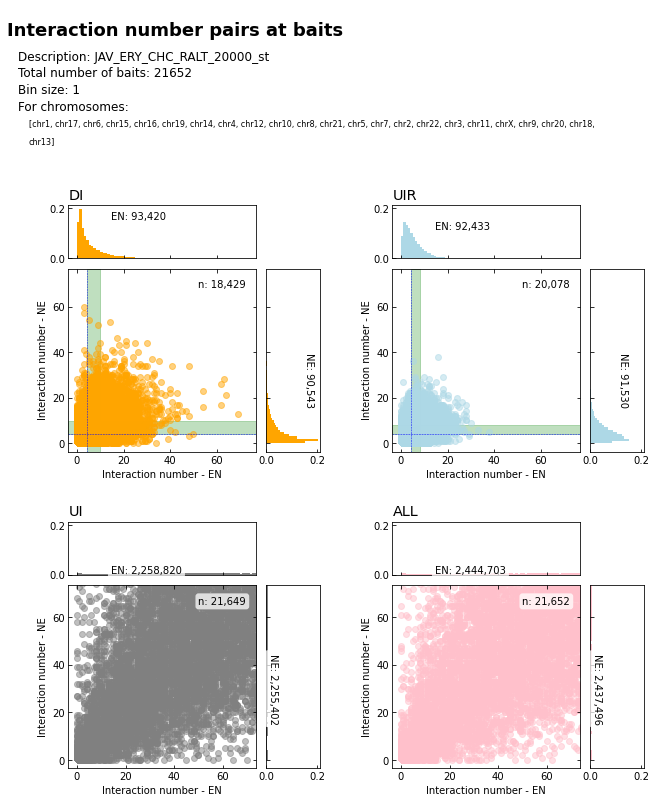

In [14]:
fig = baited_digest_set.get_pair_scatter_plots_with_histograms(
    pairs_dict = i_num_pair_dict,
    draw_mean_and_sd = True,
    set_xy_max = 70,
    sup_title = 'Interaction number pairs at baits',
    description = OUT_PREFIX,
    pdf_file_name = OUT_PREFIX + '_i_num_pairs_scatter_plots_with_histograms.pdf'
)

### Read pair number pairs

In [15]:
rp_num_pairs_dict = baited_digest_set.get_number_pairs_at_baits(
    number_pair_type='RP_NUM',
    #chromosomes=['chr22']
    verbose = True
)

[INFO] Determining pairs of read pair numbers (to the left and right) at baits ...
	[INFO] Processing chromosome chr1 ...
	[INFO] Processing chromosome chr17 ...
	[INFO] Processing chromosome chr6 ...
	[INFO] Processing chromosome chr15 ...
	[INFO] Processing chromosome chr16 ...
	[INFO] Processing chromosome chr19 ...
	[INFO] Processing chromosome chr14 ...
	[INFO] Processing chromosome chr4 ...
	[INFO] Processing chromosome chr12 ...
	[INFO] Processing chromosome chr10 ...
	[INFO] Processing chromosome chr8 ...
	[INFO] Processing chromosome chr21 ...
	[INFO] Processing chromosome chr5 ...
	[INFO] Processing chromosome chr7 ...
	[INFO] Processing chromosome chr2 ...
	[INFO] Processing chromosome chr22 ...
	[INFO] Processing chromosome chr3 ...
	[INFO] Processing chromosome chr11 ...
	[INFO] Processing chromosome chrX ...
	[INFO] Processing chromosome chr9 ...
	[INFO] Processing chromosome chr20 ...
	[INFO] Processing chromosome chr18 ...
	[INFO] Processing chromosome chr13 ...
[INFO] 

0.005054859189321179
0.004367068433110867
0.00042745623354427457
0.0004131719933493442
0.0052933962776059475
0.004410997111266062
0.00044168321862441686
0.000428043598743765
0.0052933962776059475


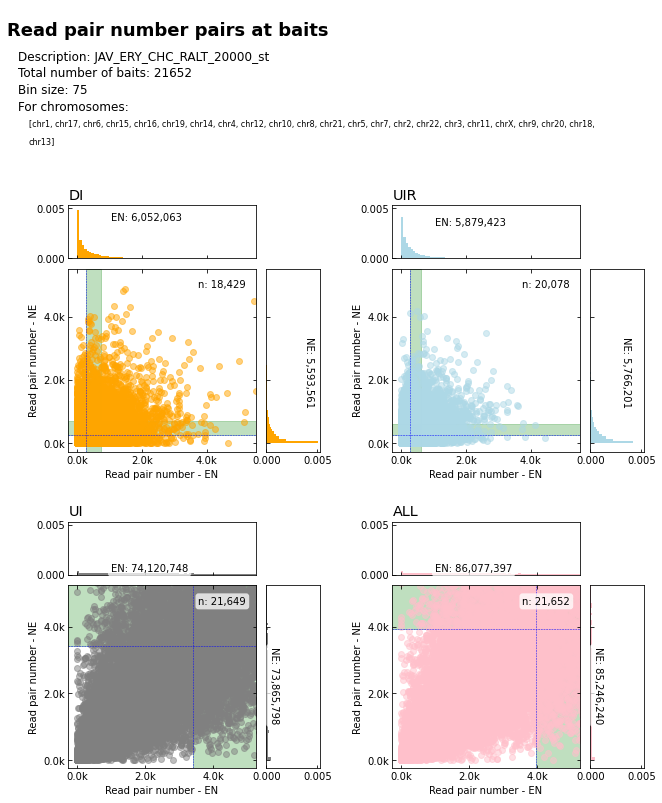

In [16]:
fig = baited_digest_set.get_pair_scatter_plots_with_histograms(
    pairs_dict = rp_num_pairs_dict,
    draw_mean_and_sd=True,
    set_xy_max = 5000,
    sup_title = 'Read pair number pairs at baits',
    description = OUT_PREFIX,
    pdf_file_name = OUT_PREFIX + '_rp_num_pairs_scatter_plots_with_histograms.pdf'
)

### Median read pair number pairs

In [17]:
med_rp_num_pairs_dict = baited_digest_set.get_number_pairs_at_baits(
    number_pair_type='MED_RP_NUM',
    #chromosomes=['chr22']
    verbose = True
)

[INFO] Determining pairs of median read pair numbers (to the left and right) at baits ...
	[INFO] Processing chromosome chr1 ...
	[INFO] Processing chromosome chr17 ...
	[INFO] Processing chromosome chr6 ...
	[INFO] Processing chromosome chr15 ...
	[INFO] Processing chromosome chr16 ...
	[INFO] Processing chromosome chr19 ...
	[INFO] Processing chromosome chr14 ...
	[INFO] Processing chromosome chr4 ...
	[INFO] Processing chromosome chr12 ...
	[INFO] Processing chromosome chr10 ...
	[INFO] Processing chromosome chr8 ...
	[INFO] Processing chromosome chr21 ...
	[INFO] Processing chromosome chr5 ...
	[INFO] Processing chromosome chr7 ...
	[INFO] Processing chromosome chr2 ...
	[INFO] Processing chromosome chr22 ...
	[INFO] Processing chromosome chr3 ...
	[INFO] Processing chromosome chr11 ...
	[INFO] Processing chromosome chrX ...
	[INFO] Processing chromosome chr9 ...
	[INFO] Processing chromosome chr20 ...
	[INFO] Processing chromosome chr18 ...
	[INFO] Processing chromosome chr13 ...


0.018908717239133975
0.01887233539197131
0.06500357984202504
0.06325483789026418
0.02016929838840957
0.019212259687219842
0.06514302046283893
0.06342456816922225
0.06514302046283893


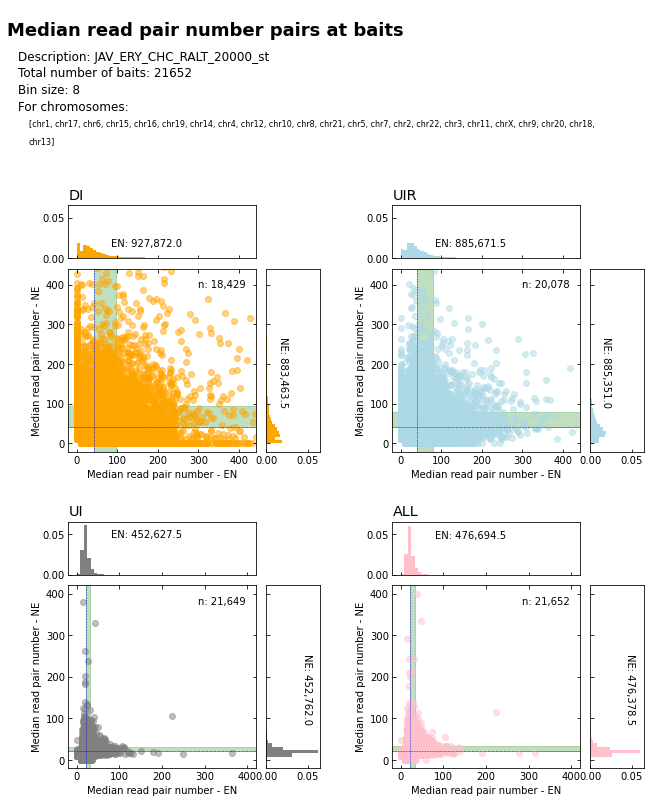

In [22]:
fig = baited_digest_set.get_pair_scatter_plots_with_histograms(
    pairs_dict = med_rp_num_pairs_dict,
    draw_mean_and_sd=True,
    set_xy_max = 400,
    sup_title = 'Median read pair number pairs at baits',
    description = OUT_PREFIX,
    pdf_file_name = OUT_PREFIX + '_med_rp_num_pairs_scatter_plots_with_histograms.pdf'
)

### Median distance pairs

In [23]:
med_i_dist_pair_dict = baited_digest_set.get_number_pairs_at_baits(
    number_pair_type='MED_I_DIST',
    #chromosomes=['chr22'],
    verbose = True
)

[INFO] Determining pairs of median interaction distances (to the left and right) at baits ...
	[INFO] Processing chromosome chr1 ...
	[INFO] Processing chromosome chr17 ...
	[INFO] Processing chromosome chr6 ...
	[INFO] Processing chromosome chr15 ...
	[INFO] Processing chromosome chr16 ...
	[INFO] Processing chromosome chr19 ...
	[INFO] Processing chromosome chr14 ...
	[INFO] Processing chromosome chr4 ...
	[INFO] Processing chromosome chr12 ...
	[INFO] Processing chromosome chr10 ...
	[INFO] Processing chromosome chr8 ...
	[INFO] Processing chromosome chr21 ...
	[INFO] Processing chromosome chr5 ...
	[INFO] Processing chromosome chr7 ...
	[INFO] Processing chromosome chr2 ...
	[INFO] Processing chromosome chr22 ...
	[INFO] Processing chromosome chr3 ...
	[INFO] Processing chromosome chr11 ...
	[INFO] Processing chromosome chrX ...
	[INFO] Processing chromosome chr9 ...
	[INFO] Processing chromosome chr20 ...
	[INFO] Processing chromosome chr18 ...
	[INFO] Processing chromosome chr13 

4.566851590933307e-06
3.203042243895235e-06
2.559296732528836e-06
2.5775991379066482e-06
4.511112453303978e-06
3.181485516661554e-06
2.561429257667908e-06
2.5898594584881507e-06
4.566851590933307e-06


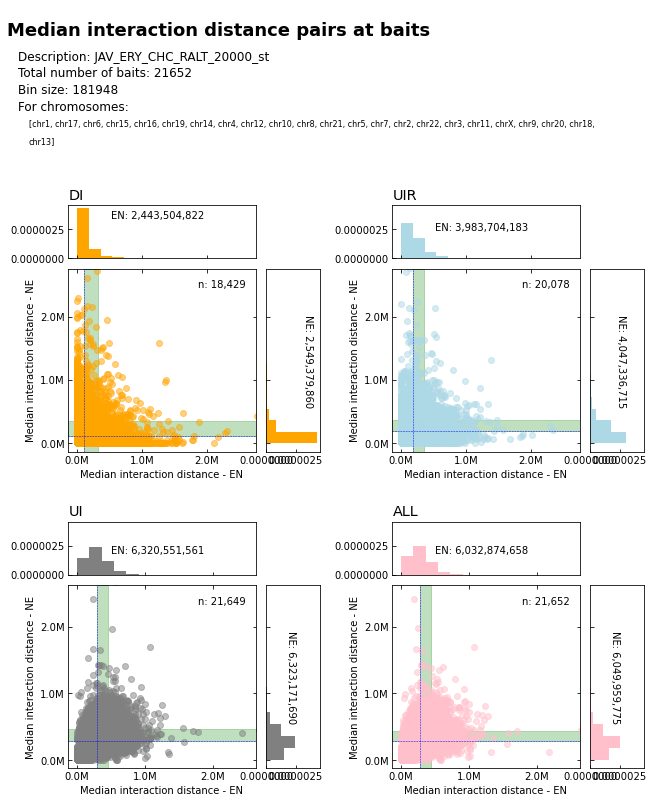

In [26]:
fig = baited_digest_set.get_pair_scatter_plots_with_histograms(
    pairs_dict = med_i_dist_pair_dict,
    draw_mean_and_sd=True,
    set_xy_max = 2500000,
    sup_title = 'Median interaction distance pairs at baits',
    description = OUT_PREFIX,
    pdf_file_name = OUT_PREFIX + '_med_i_dist_pairs_scatter_plots_with_histograms.pdf'
)

### Digest lengths (provisionally)

Here, not `NE` and `EN` are compared, but the lengths of digest pairs of interactions. In this way, the framework with the `num_pair`  dictionary and the 2x2 grid of scatterplots can be used for a quick visulalization.

First, we reload the interactions because, above, we haad already filtered out interactions with extreme digest pairs.

In [ ]:
d11_interaction_set = DiachromaticInteractionSet()
d11_interaction_set.parse_file(i_file=INTERACTION_FILE, verbose=True)

#d11_interaction_set.remove_digest_length_outliers(dg_min_len = 500, dg_max_len = 10000, dg_min_len_q = 0.25, verbose =  True)
#d11_interaction_set.remove_digest_length_outliers(dg_min_len = 0, dg_max_len = 500, dg_min_len_q = 0.25, verbose =  True)

d11_interaction_set.shuffle_inter_dict(random_seed = 1, verbose = True)
report_dict = d11_interaction_set.select_reference_interactions_2(verbose=True)
baited_digest_set = BaitedDigestSet()
read_interactions_info_dict = baited_digest_set.ingest_interaction_set(d11_interaction_set, verbose=True)

[INFO] Parsing Diachromatic interaction file ...
	[INFO] ../DICer_interactions/HT/JAV_MK_RALT_20000_evaluated_and_categorized_interactions.tsv.gz
	[INFO] Parsed 1,000,000 interaction lines ...
	[INFO] Parsed 2,000,000 interaction lines ...
	[INFO] Parsed 3,000,000 interaction lines ...
	[INFO] Parsed 4,000,000 interaction lines ...


A new number pair type `DIG_LEN` has been added to function `get_number_pairs_at_baits`.

In [58]:
dig_len_pair_dict = baited_digest_set.get_number_pairs_at_baits(
    number_pair_type='DIG_LEN',
    verbose=True
)

[INFO] Determining pairs of digest lengths (to the left and right) at baits ...
	[INFO] Processing chromosome chr21 ...
	[INFO] Processing chromosome chr22 ...
[INFO] ... done.


The dictionary now contains pairs of digest lengths for each interaction in the various categories.

In [59]:
print(dig_len_pair_dict['DI']['NE'][0])
print(dig_len_pair_dict['DI']['EN'][0])

1080
4124


Now the medians of the lengths in the different categories can be easily calculated and compared.

In [60]:
from numpy import median, mean, quantile

print("Median of shorter digest lengths DI: " + str(median(dig_len_pair_dict['DI']['NE'])))
print("Median of longer digest lengths DI: " + str(median(dig_len_pair_dict['DI']['EN'])))
print()
print("Median of shorter digest lengths UIR: " + str(median(dig_len_pair_dict['UIR']['NE'])))
print("Median of longer digest lengths UIR: " + str(median(dig_len_pair_dict['UIR']['EN'])))
print()
print("Median of shorter digest lengths UI: " + str(median(dig_len_pair_dict['UI']['NE'])))
print("Median of longer digest lengths UI: " + str(median(dig_len_pair_dict['UI']['EN'])))
print()
print("Median of shorter digest lengths ALL: " + str(median(dig_len_pair_dict['ALL']['NE'])))
print("Median of longer digest lengths ALL: " + str(median(dig_len_pair_dict['ALL']['EN'])))

Median of shorter digest lengths DI: 2197.0
Median of longer digest lengths DI: 8514.0

Median of shorter digest lengths UIR: 2192.0
Median of longer digest lengths UIR: 7040.0

Median of shorter digest lengths UI: 2180.0
Median of longer digest lengths UI: 7284.0

Median of shorter digest lengths ALL: 2181.0
Median of longer digest lengths ALL: 7321.0


The quotients of the shorter and longer lengths can also be calculated and compared.

In [61]:
diq = []
for i in range(0,len(dig_len_pair_dict['DI']['NE'])):
    diq.append(dig_len_pair_dict['DI']['NE'][i]/dig_len_pair_dict['DI']['EN'][i])
print("Mean of quotiens of digest lengths DI: " + str(round(mean(diq),2)))
print("Quantiles of quotiens of digest lengths DI: " + str(quantile(diq, [0.25,0.50,0.75])))
print()
uirq = []
for i in range(0,len(dig_len_pair_dict['UIR']['NE'])):
    uirq.append(dig_len_pair_dict['UIR']['NE'][i]/dig_len_pair_dict['UIR']['EN'][i])
print("Mean of quotiens of digest lengths UIR: " + str(round(mean(uirq),2)))
print("Quantiles of quotiens of digest lengths UIR: " + str(quantile(uirq, [0.25,0.50,0.75])))
print()
uiq = []
for i in range(0,len(dig_len_pair_dict['UI']['NE'])):
    uiq.append(dig_len_pair_dict['UI']['NE'][i]/dig_len_pair_dict['UI']['EN'][i])
print("Mean of quotiens of digest lengths UI: " + str(round(mean(uiq),2)))
print("Quantiles of quotiens of digest lengths UI: " + str(quantile(uiq, [0.25,0.50,0.75])))
print()
allq = []
for i in range(0,len(dig_len_pair_dict['ALL']['NE'])):
    allq.append(dig_len_pair_dict['ALL']['NE'][i]/dig_len_pair_dict['ALL']['EN'][i])
print("Mean of quotiens of digest lengths ALL: " + str(round(mean(allq),2)))
print("Quantiles of quotiens of digest lengths ALL: " + str(quantile(allq, [0.25,0.50,0.75])))

Mean of quotiens of digest lengths DI: 0.34
Quantiles of quotiens of digest lengths DI: [0.08711721 0.27429184 0.55292872]

Mean of quotiens of digest lengths UIR: 0.39
Quantiles of quotiens of digest lengths UIR: [0.14898087 0.33410944 0.59297316]

Mean of quotiens of digest lengths UI: 0.39
Quantiles of quotiens of digest lengths UI: [0.14634146 0.32953466 0.59771454]

Mean of quotiens of digest lengths ALL: 0.38
Quantiles of quotiens of digest lengths ALL: [0.14404344 0.32709061 0.59556467]


Finally, the 2x2 grid with the scatterplots is created. We create the dictionary `dig_len_pair_dict` again for only one chromosome because otherwise the scatterplot would become too big.

[INFO] Determining pairs of digest lengths (to the left and right) at baits ...
	[INFO] Processing chromosome chr22 ...
[INFO] ... done.


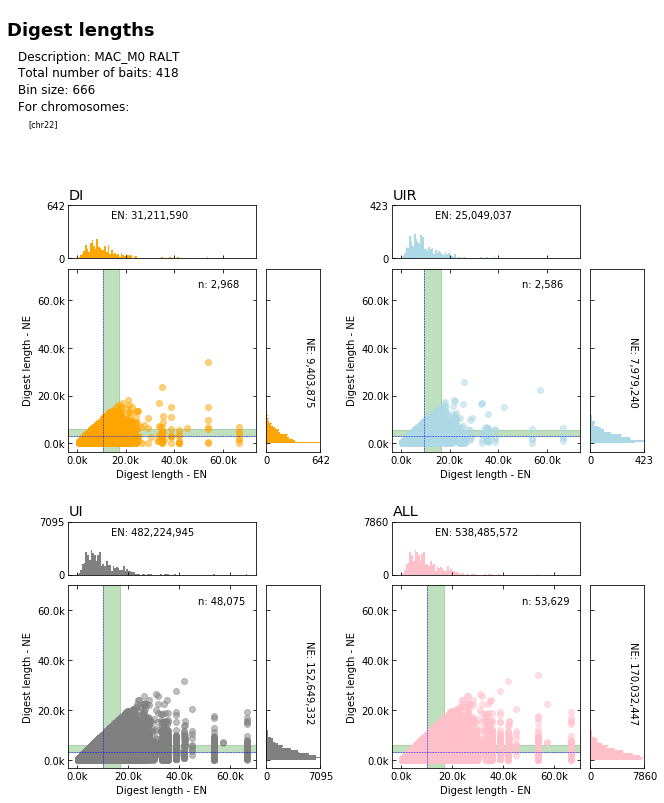

In [62]:
dig_len_pair_dict = baited_digest_set.get_number_pairs_at_baits(
    number_pair_type='DIG_LEN',
    chromosomes=['chr22'],
    verbose=True
)
fig = baited_digest_set.get_pair_scatter_plots_with_histograms(
    pairs_dict = dig_len_pair_dict,
    draw_mean_and_sd = True,
    #set_xy_max = 20000,
    sup_title = 'Digest lengths',
    description = 'MAC_M0 RALT',
    pdf_file_name ='MAC_M0_RALT_dig_len_pairs_scatter_plots_with_histograms.pdf'
)

To get an impression of the effects of filtering interactions with extreme digest pairs, repeat the analyzes from this section after uncommenting the relevant line (`remove_digest_length_outliers`) at the beginning.

## Proportion of directed interactions on individual chromosomes  (provisionally)

In [63]:
baited_digest_set.proportion_of_directed_interactions_on_individual_chromosomes()

262
chr21	52843	2093	0.04	0.05	0.48	0.47
418
chr22	53629	2968	0.06	0.05	0.51	0.51


## BaitedDigest key sorted by starting position (provisionally)

In [64]:
sorted_baited_digest_keys = baited_digest_set.get_baited_digest_keys_sorted_by_sta_pos()
for i in sorted_baited_digest_keys['chr22']:
    print(i)

chr22	16818640	16825948
chr22	17004466	17011585
chr22	17078723	17092243
chr22	17116729	17122470
chr22	17158523	17165407
chr22	17247624	17269016
chr22	17358660	17367331
chr22	17625009	17633327
chr22	17771846	17783296
chr22	17976670	17982933
chr22	18021792	18025855
chr22	18076869	18090126
chr22	18107010	18112573
chr22	18145621	18150468
chr22	19111150	19132339
chr22	19141629	19145046
chr22	19146350	19158547
chr22	19175210	19181611
chr22	19290242	19296281
chr22	19427912	19434092
chr22	19434093	19449912
chr22	19472999	19485346
chr22	19526639	19531205
chr22	19704203	19722313
chr22	19722314	19741175
chr22	19756458	19757522
chr22	19940745	19950116
chr22	20003784	20020920
chr22	20029363	20033885
chr22	20083394	20096034
chr22	20111600	20116672
chr22	20116673	20118239
chr22	20124106	20138526
chr22	20181708	20211956
chr22	20246695	20258491
chr22	20262801	20283292
chr22	20388957	20403343
chr22	20412904	20424609
chr22	20434852	20440860
chr22	20494762	20504036
chr22	20520286	20537480
chr22	20720187	2

## Filter interactions by ht tag

In [9]:
# Filter out interactions that might be affected by unbalanced baits
d11_interaction_set = DiachromaticInteractionSet(rpc_rule = 'ht')
d11_interaction_set.parse_file(
    i_file = INTERACTION_FILE,
    verbose = True)

print("[INFO] Filtering interaction set ...")
filtered_interaction_set = DiachromaticInteractionSet(rpc_rule = 'ht')
for d_inter in d11_interaction_set.interaction_list:
    
    #if d_inter.get_category() == 'DI' or d_inter.get_category() == 'DIX':
    
    #if d_inter.get_ht_tag() == '02' and d_inter.enrichment_status_tag_pair == 'NE':
        #continue
    #if d_inter.get_ht_tag() == '13' and d_inter.enrichment_status_tag_pair == 'NE':
        #continue
    #if d_inter.get_ht_tag() == '12' and d_inter.enrichment_status_tag_pair == 'EN':
        #continue
    #if d_inter.get_ht_tag() == '03' and d_inter.enrichment_status_tag_pair == 'EN':
        #continue
        
    filtered_interaction_set._inter_dict[d_inter.key] = d_inter

for d_inter in filtered_interaction_set.interaction_list:
    if d_inter.get_category() == 'DI' and (d_inter.get_ht_tag() == '02' or d_inter.get_ht_tag() == '03' or d_inter.get_ht_tag() == '12' or d_inter.get_ht_tag() == '13'):
    #if d_inter.get_category() == 'DI' and (d_inter.get_ht_tag() == '0X' or d_inter.get_ht_tag() == '1X' or d_inter.get_ht_tag() == '2X' or d_inter.get_ht_tag() == '3X'):
    #if d_inter.get_category() == 'DI' and (d_inter.get_ht_tag() == '01' or d_inter.get_ht_tag() == '23'):
        d_inter.set_category('DI')
    else:
        d_inter.set_category('UI')
    
print("[INFO] ... done.")

filtered_interaction_set.select_reference_interactions(verbose=True)
x = filtered_interaction_set.write_diachromatic_interaction_file(
    target_file = 'HT001_FILTER_2' + '/' + CELL_TYPE_SHORT + '_filtered_interaction_set.tsv.gz',
    verbose = True)

[INFO] Parsing Diachromatic interaction file ...
	[INFO] ../DICer_interactions/ST/FDR005/CHC/JAV_MK_RALT_20000_st_fdr0.05_evaluated_and_categorized_interactions.tsv.gz
	[INFO] Parsed 1,000,000 interaction lines ...
	[INFO] Parsed 2,000,000 interaction lines ...
	[INFO] Parsed 3,000,000 interaction lines ...
	[INFO] Parsed 4,000,000 interaction lines ...
	[INFO] Parsed 5,000,000 interaction lines ...
	[INFO] Set size: 5,249,507
[INFO] ... done.
[INFO] Filtering interaction set ...
[INFO] ... done.
[INFO] Select reference interactions ...
	[INFO] Treating NE and EN as one category ...
	[INFO] First pass: Count directed interactions for different read pair counts ...
	[INFO] Second pass: Select undirected reference interactions for different read pair counts ...
	[INFO] Third pass: Moving DI interactions for which there is no reference to DIX ...
[INFO] ... done.
[INFO] Writing Diachromatic interaction file ...
	[INFO] Required replicates: 1
	[INFO] Target file: HT001_FILTER_2/MK_filtered

## Pool datasets

In [ ]:
# Pool ST or HT datasets
PROTOCOL = 'CHC'
MIN_I_DIST = '20000'
if PROTOCOL == 'CHC':
    MIN_I_DIST = '20000'
RPC_RULE = 'ht'
FDR = '01'
pooled_interaction_set = DiachromaticInteractionSet(rpc_rule = RPC_RULE)
for CELL_TYPE_SHORT in ['MK', 'ERY', 'MON', 'NEU', 'MAC_M0', 'MAC_M1', 'MAC_M2']:
    INTERACTION_FILE = '../DICer_interactions/' + RPC_RULE.upper() + '/FDR0' + FDR + '/CHC/JAV_' + CELL_TYPE_SHORT + '_RALT_20000_' + RPC_RULE + '_fdr0.' + FDR + '_evaluated_and_categorized_interactions.tsv.gz'
    pooled_interaction_set.parse_file(
    i_file = INTERACTION_FILE,
    verbose = True)

pooled_interaction_set.evaluate_and_categorize_interactions(pval_thresh=0.001, verbose=True)
pooled_interaction_set.select_reference_interactions(verbose=True)
write_report_dict = pooled_interaction_set.write_diachromatic_interaction_file(
    target_file = 'pooled_interaction_set.tsv.gz',
    verbose = True)

## Analyse HT tags at baited digests

In [27]:
def get_ht_freq_dicts(interaction_list):
    
    HT_TAG_FREQ_DICT = {
        'DIX': {
            'NN': {'01': 0,'02': 0,'03': 0,'12': 0,'13': 0,'23': 0},
            'EE': {'01': 0,'02': 0,'03': 0,'12': 0,'13': 0,'23': 0},
            'NE': {'01': 0,'02': 0,'03': 0,'12': 0,'13': 0,'23': 0},
            'EN': {'01': 0,'02': 0,'03': 0,'12': 0,'13': 0,'23': 0},
            'ALL': {'01': 0,'02': 0,'03': 0,'12': 0,'13': 0,'23': 0}
        },
        'DI': {
            'NN': {'01': 0,'02': 0,'03': 0,'12': 0,'13': 0,'23': 0},
            'EE': {'01': 0,'02': 0,'03': 0,'12': 0,'13': 0,'23': 0},
            'NE': {'01': 0,'02': 0,'03': 0,'12': 0,'13': 0,'23': 0},
            'EN': {'01': 0,'02': 0,'03': 0,'12': 0,'13': 0,'23': 0},
            'ALL': {'01': 0,'02': 0,'03': 0,'12': 0,'13': 0,'23': 0}
        },
        'UIR': {
            'NN': {'01': 0,'02': 0,'03': 0,'12': 0,'13': 0,'23': 0},
            'EE': {'01': 0,'02': 0,'03': 0,'12': 0,'13': 0,'23': 0},
            'NE': {'01': 0,'02': 0,'03': 0,'12': 0,'13': 0,'23': 0},
            'EN': {'01': 0,'02': 0,'03': 0,'12': 0,'13': 0,'23': 0},
            'ALL': {'01': 0,'02': 0,'03': 0,'12': 0,'13': 0,'23': 0}
        },
        'UI': {
            'NN': {'01': 0,'02': 0,'03': 0,'12': 0,'13': 0,'23': 0},
            'EE': {'01': 0,'02': 0,'03': 0,'12': 0,'13': 0,'23': 0},
            'NE': {'01': 0,'02': 0,'03': 0,'12': 0,'13': 0,'23': 0},
            'EN': {'01': 0,'02': 0,'03': 0,'12': 0,'13': 0,'23': 0},
            'ALL': {'01': 0,'02': 0,'03': 0,'12': 0,'13': 0,'23': 0}
        },
        'ALL': {
            'NN': {'01': 0,'02': 0,'03': 0,'12': 0,'13': 0,'23': 0},
            'EE': {'01': 0,'02': 0,'03': 0,'12': 0,'13': 0,'23': 0},
            'NE': {'01': 0,'02': 0,'03': 0,'12': 0,'13': 0,'23': 0},
            'EN': {'01': 0,'02': 0,'03': 0,'12': 0,'13': 0,'23': 0},
            'ALL': {'01': 0,'02': 0,'03': 0,'12': 0,'13': 0,'23': 0}
        }
    }

    # Get absolute frequencies
    for d11_inter in interaction_list:
        i_cat = d11_inter.get_category()
        e_cat = d11_inter.enrichment_status_tag_pair
        HT_TAG_FREQ_DICT[i_cat][e_cat][d11_inter.get_ht_tag()] += 1
        HT_TAG_FREQ_DICT['ALL'][e_cat][d11_inter.get_ht_tag()] += 1
        HT_TAG_FREQ_DICT[i_cat]['ALL'][d11_inter.get_ht_tag()] += 1
        HT_TAG_FREQ_DICT['ALL']['ALL'][d11_inter.get_ht_tag()] += 1

    # Fill second dictionary with realtive frequencies
    HT_TAG_DENS_DICT = copy.deepcopy(HT_TAG_FREQ_DICT)
    for i_cat in ['DIX','DI','UIR','UI','ALL']:
        for e_cat in ['NN','EE','NE','EN','ALL']:
            i_total = sum(HT_TAG_FREQ_DICT[i_cat][e_cat].values())
            if 0 < i_total:
                for ht_tag in ['01','02','03','12','13','23']:
                    HT_TAG_DENS_DICT[i_cat][e_cat][ht_tag] = HT_TAG_FREQ_DICT[i_cat][e_cat][ht_tag]/i_total
            else:
                for ht_tag in ['01','02','03','12','13','23']:
                    HT_TAG_DENS_DICT[i_cat][e_cat][ht_tag] = 0.0
                    
    return HT_TAG_FREQ_DICT, HT_TAG_DENS_DICT

In [ ]:
baited_digest = list(baited_digest_set._baited_digest_dict['chr10'].values())[4]
baited_digest_key = list(baited_digest_set._baited_digest_dict['chr10'].keys())[5]
interaction_list =  []
for i_cat in ['DIX', 'DI', 'UIR', 'UI', 'ALL']:    
    interaction_list = interaction_list + baited_digest.interactions[i_cat]['NE'] + baited_digest.interactions[i_cat]['EN']

HT_TAG_FREQ_DICT, HT_TAG_DENS_DICT = get_ht_freq_dicts(interaction_list)
sum_0112 = HT_TAG_FREQ_DICT['ALL']['NE']['02'] + HT_TAG_FREQ_DICT['ALL']['EN']['12']
sum_0313 = HT_TAG_FREQ_DICT['ALL']['NE']['13'] + HT_TAG_FREQ_DICT['ALL']['EN']['03']
sum_0112 = HT_TAG_FREQ_DICT['ALL']['NE']['02'] + HT_TAG_FREQ_DICT['ALL']['EN']['12']
sum_0313 = HT_TAG_FREQ_DICT['ALL']['NE']['13'] + HT_TAG_FREQ_DICT['ALL']['EN']['03']
if sum_0112 < sum_0313:
    imbalanced_bait_score = (sum_0112 + 1)/(sum_0313 + 1)
else:
    imbalanced_bait_score = (sum_0313 + 1)/(sum_0112 + 1)
print(sum_0112)
print(sum_0313)
print(imbalanced_bait_score)
print(baited_digest_key)

In [ ]:
baited_digest = list(baited_digest_set._baited_digest_dict['chr10'].values())[55]
interaction_list =  []
for i_cat in ['DIX', 'DI', 'UIR', 'UI', 'ALL']:    
    interaction_list = interaction_list + baited_digest.interactions[i_cat]['NE'] + baited_digest.interactions[i_cat]['EN']

HT_TAG_FREQ_DICT, HT_TAG_DENS_DICT = get_ht_freq_dicts(interaction_list)
for i_cat in ['DIX', 'DI', 'UIR', 'UI', 'ALL']:
    print(i_cat)
    for e_cat in ['NE', 'EN', 'ALL']:
        print('\t\t' + e_cat, end='')
    print()
    for ht_tag in ['02', '12', '03', '13']:
        print('\t' + ht_tag + ': ', end='')
        for e_cat in ['NE', 'EN', 'ALL']:
            print('\t' + "{:,}".format(HT_TAG_FREQ_DICT[i_cat][e_cat][ht_tag]), end='')
            print(' (' + "{:.2f}".format(HT_TAG_DENS_DICT[i_cat][e_cat][ht_tag]) + ')', end='')
        print()
        
sum_0112 = HT_TAG_FREQ_DICT['ALL']['NE']['02'] + HT_TAG_FREQ_DICT['ALL']['EN']['12']
sum_0313 = HT_TAG_FREQ_DICT['ALL']['NE']['13'] + HT_TAG_FREQ_DICT['ALL']['EN']['03']
if sum_0112 < sum_0313:
    imbalanced_bait_score = (sum_0112 + 1)/(sum_0313 + 1)
else:
    imbalanced_bait_score = (sum_0313 + 1)/(sum_0112 + 1)
print(sum_0112)
print(sum_0313)
print(imbalanced_bait_score)

### For all baited digests

In [ ]:
f = open('filtered_baited_digests.bed', 'w')

filtered_interaction_set = DiachromaticInteractionSet(rpc_rule = 'ht')
balanced_baited_digest_num_total = 0
for chrom in baited_digest_set._baited_digest_dict.keys():
    print(chrom)
    balanced_baited_digest_num = 0
    for baited_digest_key, baited_digest in baited_digest_set._baited_digest_dict[chrom].items():
        #print('----')
        interaction_list =  []
        for i_cat in ['DIX', 'DI', 'UIR', 'UI', 'ALL']:    
            interaction_list = interaction_list + baited_digest.interactions[i_cat]['NE'] + baited_digest.interactions[i_cat]['EN']

        HT_TAG_FREQ_DICT, HT_TAG_DENS_DICT = get_ht_freq_dicts(interaction_list)
        sum_0212 = HT_TAG_FREQ_DICT['ALL']['NE']['02'] + HT_TAG_FREQ_DICT['ALL']['EN']['12']
        sum_0313 = HT_TAG_FREQ_DICT['ALL']['NE']['13'] + HT_TAG_FREQ_DICT['ALL']['EN']['03']
        
        if sum_0212 < sum_0313:
            imbalanced_bait_score = (sum_0212 + 1)/(sum_0313 + 1)
        else:
            imbalanced_bait_score = (sum_0313 + 1)/(sum_0212 + 1)

        if 0.90 < imbalanced_bait_score:
            balanced_baited_digest_num += 1
            balanced_baited_digest_num_total += 1
            print('----')
            print(sum_0212)
            print(sum_0313)
            print(imbalanced_bait_score)
            print(baited_digest_key)
            
            f.write(baited_digest_key + '\n')
            
        # Add all interactions at this bait to a new set
        for d_inter in interaction_list:
            if imbalanced_bait_score <= 0.75:
                if sum_0313 < sum_0212:
                    if d_inter.get_ht_tag() == '02' and d_inter.enrichment_status_tag_pair == 'NE':
                        continue
                    if d_inter.get_ht_tag() == '12' and d_inter.enrichment_status_tag_pair == 'EN':
                        continue
            else:
                if d_inter.get_ht_tag() == '13' and d_inter.enrichment_status_tag_pair == 'NE':
                    continue
                if d_inter.get_ht_tag() == '03' and d_inter.enrichment_status_tag_pair == 'EN':
                    continue                
            filtered_interaction_set._inter_dict[d_inter.key] = d_inter
            
    print('Number of balanced baited digests on ' + chrom + ': ' + str(balanced_baited_digest_num))
print(balanced_baited_digest_num_total)

# For the filtered interaction set, select reference interactions and write to file
filtered_interaction_set.select_reference_interactions(verbose=True)
x = filtered_interaction_set.write_diachromatic_interaction_file(
    target_file = 'filtered_interaction_set.tsv.gz',
    verbose = True)

f.close()

### Create file with pseudo unbalanced and associated reference interactions

1. Remove all `DI` interactions and rename all `UIR` interactions to new pseudo `DI` interactions
3. Select refernence interactions `UIR` that have half as many read pairs as compared to the pseudo `DI` interactions
4. Perform alanysis with interaction distances
5. Perform analysis with TAD boundaries

In [14]:
# Load interations
interaction_set = DiachromaticInteractionSet(rpc_rule = 'ht')
interaction_set.parse_file(
    i_file = INTERACTION_FILE,
    verbose = True)

print("[INFO] Removing all 'DI' and 'DIX' interactions and renaming UIR to DI interactions ...")
balanced_interaction_set = DiachromaticInteractionSet(rpc_rule = 'ht')
for d_inter in interaction_set.interaction_list:
    if d_inter.get_category() == 'DI' or d_inter.get_category() == 'DIX':
        continue
    else:
        if d_inter.get_category() == 'UIR':
            d_inter.set_category('DI')
        balanced_interaction_set._inter_dict[d_inter.key] = d_inter
print("[INFO] ... done.")

# Select reference interactions with greater read pair counts 
balanced_interaction_set.select_reference_interactions(rpc_factor = 0.5, verbose=True)


# Swap DI and UIR again
for d_inter in balanced_interaction_set.interaction_list:
    if d_inter.get_category() == 'DI':
        d_inter.set_category('UIR')
    elif d_inter.get_category() == 'UIR':
        d_inter.set_category('DI') 
    
report_dict = balanced_interaction_set.write_diachromatic_interaction_file(
    target_file = 'PSEUDO_DI' + '/' + CELL_TYPE_SHORT + '_pseudo_di_interaction_set.tsv.gz',
    verbose = True)
    

[INFO] Parsing Diachromatic interaction file ...
	[INFO] ../DICer_interactions/ST/FDR005/CHC/JAV_NCD8_RALT_20000_st_fdr0.05_evaluated_and_categorized_interactions.tsv.gz
	[INFO] Parsed 1,000,000 interaction lines ...
	[INFO] Parsed 2,000,000 interaction lines ...
	[INFO] Parsed 3,000,000 interaction lines ...
	[INFO] Parsed 4,000,000 interaction lines ...
	[INFO] Parsed 5,000,000 interaction lines ...
	[INFO] Set size: 5,137,855
[INFO] ... done.
[INFO] Removing all 'DI' and 'DIX' interactions and renaming UIR to DI interactions ...
[INFO] ... done.
[INFO] Select reference interactions ...
	[INFO] Treating NE and EN as one category ...
	[INFO] First pass: Count directed interactions for different read pair counts ...
	[INFO] Second pass: Select undirected reference interactions for different read pair counts ...
	[INFO] Third pass: Moving DI interactions for which there is no reference to DIX ...
[INFO] ... done.
[INFO] Writing Diachromatic interaction file ...
	[INFO] Required replicat

### Count neighbouring digests

In [85]:
PROTOCOL = 'CHC'
CELL_TYPE_SHORT = 'MAC_M0'
MIN_I_DIST = '20000'
if PROTOCOL == 'CHC':
    MIN_I_DIST = '20000'
RPC_RULE = 'st'
FDR = '05'
if PROTOCOL == 'CHC':
    INTERACTION_FILE = '../DICer_interactions/' + RPC_RULE.upper() + '/FDR0' + FDR + '/CHC/JAV_' + CELL_TYPE_SHORT + '_RALT_20000_' + RPC_RULE + '_fdr0.' + FDR + '_evaluated_and_categorized_interactions.tsv.gz'
    OUT_PREFIX = 'JAV_' + CELL_TYPE_SHORT + '_CHC_RALT_' + MIN_I_DIST + '_' + RPC_RULE.lower()
if PROTOCOL == 'HC_POOLED':
    INTERACTION_FILE = '../DICer_interactions/HT/FDR005/HC/20000/JAV_ALL_HC_RALL_ALT_20000_ht_fdr0.05_evaluated_and_categorized_interactions.tsv.gz'
    OUT_PREFIX = 'JAV_' + 'POOLED_HC_FDR005' + '_HC_RALT_20000_' + RPC_RULE.lower()
if PROTOCOL == 'HC':
    INTERACTION_FILE = '../DICer_interactions/' + RPC_RULE.upper() + '/FDR0' + FDR + '/HC/' + MIN_I_DIST + '/JAV_' + CELL_TYPE_SHORT + '_HC_RALT_' + MIN_I_DIST + '_' + RPC_RULE + '_fdr0.' + FDR + '_evaluated_and_categorized_interactions.tsv.gz'
    OUT_PREFIX = 'JAV_' + CELL_TYPE_SHORT + '_HC_RALT_'  + MIN_I_DIST + '_' + RPC_RULE.lower()

# Load interations
interaction_set = DiachromaticInteractionSet(rpc_rule = 'ht')
interaction_set.parse_file(
    i_file = INTERACTION_FILE,
    verbose = True)

[INFO] Parsing Diachromatic interaction file ...
	[INFO] ../DICer_interactions/ST/FDR005/CHC/JAV_MAC_M0_RALT_20000_st_fdr0.05_evaluated_and_categorized_interactions.tsv.gz
	[INFO] Parsed 1,000,000 interaction lines ...
	[INFO] Parsed 2,000,000 interaction lines ...
	[INFO] Parsed 3,000,000 interaction lines ...
	[INFO] Parsed 4,000,000 interaction lines ...
	[INFO] Parsed 5,000,000 interaction lines ...
	[INFO] Set size: 5,534,503
[INFO] ... done.


In [86]:
print("[INFO] Getting digest sets ...")
from_digests_dict = {
    'DIX': set(),
    'DI': set(),
    'UIR': set(),
    'UI': set(),
    'ALL': set(),
}
to_digests_dict = {
    'DIX': set(),
    'DI': set(),
    'UIR': set(),
    'UI': set(),
    'ALL': set(),
}
for d_inter in interaction_set.interaction_list:
    from_digests_dict[d_inter.get_category()].add(d_inter.chrA + '\t' + str(d_inter.fromA))
    from_digests_dict[d_inter.get_category()].add(d_inter.chrB + '\t' + str(d_inter.fromB))
    to_digests_dict[d_inter.get_category()].add(d_inter.chrA + '\t' + str(d_inter.toA))
    to_digests_dict[d_inter.get_category()].add(d_inter.chrB + '\t' + str(d_inter.toB))
    from_digests_dict['ALL'].add(d_inter.chrA + '\t' + str(d_inter.fromA))
    from_digests_dict['ALL'].add(d_inter.chrB + '\t' + str(d_inter.fromB))
    to_digests_dict['ALL'].add(d_inter.chrA + '\t' + str(d_inter.toA))
    to_digests_dict['ALL'].add(d_inter.chrB + '\t' + str(d_inter.toB))
print("[INFO] ... done.")

[INFO] Getting digest sets ...
[INFO] ... done.


In [87]:
print("[INFO] Counting neighbouring digests ...")
for i_cat in ['DIX','DI','UIR','UI','ALL']:
    print(i_cat)
    from_digest_set = from_digests_dict[i_cat]
    to_digest_set = to_digests_dict[i_cat]
    neighbour_cnt = 0
    for to_digest in to_digest_set:
        chrom, pos = to_digest.split('\t')
        from_digest_key = chrom + '\t' + str(int(pos) + 1)
        if from_digest_key in from_digest_set:
            neighbour_cnt += 1
            
    print(len(from_digest_set))
    print(len(to_digest_set))
    print('Number of neighbours: ' + str(neighbour_cnt))
    print(neighbour_cnt/len(to_digest_set))
    print('-------')
print("[INFO] ... done.")

[INFO] Counting neighbouring digests ...
DIX
632
632
Number of neighbours: 47
0.07436708860759493
-------
DI
145300
145300
Number of neighbours: 53558
0.3686028905712319
-------
UIR
192283
192283
Number of neighbours: 75341
0.3918235101387018
-------
UI
704032
704032
Number of neighbours: 658628
0.9355086132448525
-------
ALL
710914
710914
Number of neighbours: 669247
0.9413895351617777
-------
[INFO] ... done.


In [ ]:
DI
485034
485034
332024
0.6845375788089082

UIR
485526
485526
341233
0.7028109720179764

UI
665985
665985
597178
0.8966838592460791